In [ ]:
# TODO: update to new payoff signature
using IPG, IPG.JuMP, SCIP
using Random, LinearAlgebra, Plots

The random instance generation procedure is based on
> Dragotto, Gabriele, and Rosario Scatamacchia. “The Zero Regrets Algorithm: Optimizing over Pure Nash Equilibria via Integer Programming.” INFORMS Journal on Computing 35, no. 5 (September 2023): 1143–60. https://doi.org/10.1287/ijoc.2022.0282.

The original can be seen in their repository: https://github.com/gdragotto/ZeroRegretsAlgorithm

In [2]:
function generate_random_instance(n::Int, m::Int, lower_bound::Int, upper_bound::Int; i_type="H")
    factor = i_type == "H" ? 0.1 : 0.01
    RQ = 5

    # Generate positive semidefinite matrix M
    M = zeros(Float64, (n*m, n*m))
    while ~isposdef(M)
        M = rand(Float64, (n*m, n*m))
        M = (M .* 2 .- 1) .* RQ  # scaling
        M = M * M'
    end

    M_max = maximum(M)
    for i in 1:n
        for j in ((i-1) * m + 1):(i * m)
            for k in (i * m + 1):(size(M, 2))
                vjk = (rand() * 2 - 1) * factor * M_max
                vjk = round(vjk, digits=1)
                M[j, k] += vjk
                M[k, j] -= vjk
            end
        end
    end

    # build players
    players = Vector{Player{QuadraticPayoff}}()
    for p in 1:n
        # build payoff
        Qp = Vector{Matrix{Float64}}()
        for k in 1:n
            push!(Qp, M[((p-1) * m + 1):(p * m), ((k-1) * m + 1):(k * m)])
        end

        cp = rand(-RQ:RQ, m)
        Πp = QuadraticPayoff(cp, Qp)

        # build strategy space
        Xp = Model()
        @variable(Xp, lower_bound <= x[1:m] <= upper_bound, Int)

        push!(players, Player(Xp, Πp, p))
    end

    return players
end

generate_random_instance (generic function with 1 method)

In [3]:
players = generate_random_instance(2, 1, -500, 500)

# IPG.initialize_strategies = IPG.initialize_strategies_player_alone
IPG.initialize_strategies = IPG.initialize_strategies_feasibility

Σ, payoff_improvements = IPG.SGM(players, SCIP.Optimizer, max_iter=25, verbose=true)

Game initialized with strategies: [[[500.0]], [[500.0]]]
Iter 1
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[500.0]]), DiscreteMixedStrategy([1.0], [[500.0]])]
Deviation found for player 2 with payoff improvement 1.3531201065733988e7
New strategy added for player 2: [-500.0]
Iter 2
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[500.0]]), DiscreteMixedStrategy([1.0], [[-500.0]])]
Deviation found for player 1 with payoff improvement 397566.0109574138
New strategy added for player 1: [349.0]
Iter 3
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[349.0]]), DiscreteMixedStrategy([1.0], [[-500.0]])]
Deviation found for player 2 with payoff improvement 71478.74083510647
New strategy added for player 2: [-420.0]
Iter 4
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[349.0]]), DiscreteMixedStrategy([1.0], [[-420.0]])]
Deviation found for player 

(Vector{DiscreteMixedStrategy}[[DiscreteMixedStrategy([1.0], [[500.0]]), DiscreteMixedStrategy([1.0], [[500.0]])], [DiscreteMixedStrategy([1.0], [[500.0]]), DiscreteMixedStrategy([1.0], [[-500.0]])], [DiscreteMixedStrategy([1.0], [[349.0]]), DiscreteMixedStrategy([1.0], [[-500.0]])], [DiscreteMixedStrategy([1.0], [[349.0]]), DiscreteMixedStrategy([1.0], [[-420.0]])], [DiscreteMixedStrategy([1.0], [[292.9999999999709]]), DiscreteMixedStrategy([1.0], [[-420.0]])], [DiscreteMixedStrategy([1.0], [[292.9999999999709]]), DiscreteMixedStrategy([1.0], [[-353.0]])], [DiscreteMixedStrategy([1.0], [[247.00000000001353]]), DiscreteMixedStrategy([1.0], [[-353.0]])], [DiscreteMixedStrategy([0.9999999999999999], [[247.00000000001353]]), DiscreteMixedStrategy([0.9999999999999999], [[-297.0]])], [DiscreteMixedStrategy([1.0], [[207.0]]), DiscreteMixedStrategy([1.0], [[-297.0]])], [DiscreteMixedStrategy([0.9999999999999999], [[207.0]]), DiscreteMixedStrategy([1.0], [[-249.0]])]  …  [DiscreteMixedStrategy

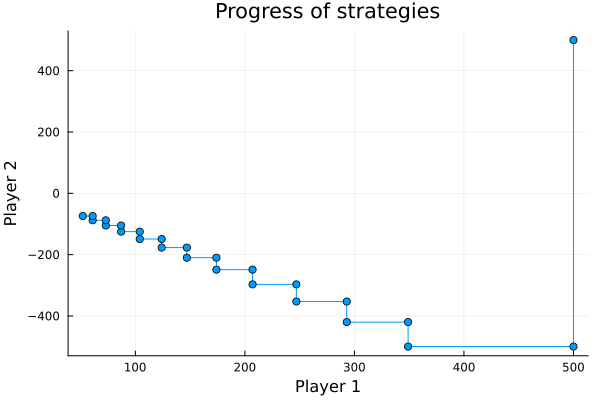

In [4]:
p1_strategies = [expected_value(identity, σk[1])[1] for σk in Σ]
p2_strategies = [expected_value(identity, σk[2])[1] for σk in Σ]

plot(p1_strategies, p2_strategies, marker=:c, title="Progress of strategies", legend=false)
xlabel!("Player 1")
ylabel!("Player 2")

In [10]:
players = generate_random_instance(3, 3, -50, 50)

# IPG.initialize_strategies = IPG.initialize_strategies_player_alone
IPG.initialize_strategies = IPG.initialize_strategies_feasibility

Σ, payoff_improvements = IPG.SGM(players, SCIP.Optimizer, max_iter=25, verbose=true)

Game initialized with strategies: [[[50.0, 50.0, 50.0]], [[50.0, 50.0, 50.0]], [[50.0, 50.0, 50.0]]]
Iter 1
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]])]
Deviation found for player 2 with payoff improvement 576155.2134977959
New strategy added for player 2: [-41.0, 1.0, 21.0]
Iter 2
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[-41.0, 1.0, 21.0]]), DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]])]
Deviation found for player 3 with payoff improvement 528725.3680526916
New strategy added for player 3: [0.0, 5.0, -42.0]
Iter 3
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[-41.0, 1.0, 21.0]]), DiscreteMixedStrategy([1.0], [[0.0, 5.0, -42.0]])]
Devi

(Vector{DiscreteMixedStrategy}[[DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]])], [DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[-41.0, 1.0, 21.0]]), DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]])], [DiscreteMixedStrategy([1.0], [[50.0, 50.0, 50.0]]), DiscreteMixedStrategy([1.0], [[-41.0, 1.0, 21.0]]), DiscreteMixedStrategy([1.0], [[0.0, 5.0, -42.0]])], [DiscreteMixedStrategy([1.0], [[11.0, 16.0, 39.0]]), DiscreteMixedStrategy([1.0], [[-41.0, 1.0, 21.0]]), DiscreteMixedStrategy([1.0], [[0.0, 5.0, -42.0]])], [DiscreteMixedStrategy([1.0], [[11.0, 16.0, 39.0]]), DiscreteMixedStrategy([1.0], [[0.0, 7.0, 3.0]]), DiscreteMixedStrategy([1.0], [[0.0, 5.0, -42.0]])], [DiscreteMixedStrategy([1.0], [[11.0, 16.0, 39.0]]), DiscreteMixedStrategy([1.0], [[0.0, 7.0, 3.0]]), DiscreteMixedStrategy([1.0], [[-24.0, 6.0, -37.0]])], [DiscreteMixedStrategy([1.0],

## Equivalence of bilateral payoff and two-player blackbox

In [26]:
IPG.initialize_strategies = IPG.initialize_strategies_player_alone

bilateral_players = generate_random_instance(2, 2, -5, 5)
for player in bilateral_players
    for variable in all_variables(player.Xp)
        set_start_value(variable, 1.0)
    end
end

# "black-box" function for blackbox payoff players
function blackbox_payoff(x, p)
    return payoff(bilateral_players[p].Πp, x, p)
end

blackbox_players = [
    Player(copy(player.Xp), BlackBoxPayoff(blackbox_payoff), player.p)
    for player in bilateral_players
]

2-element Vector{Player{BlackBoxPayoff}}:
 Player{BlackBoxPayoff}(A JuMP Model
├ solver: none
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 2
├ num_constraints: 6
│ ├ VariableRef in MOI.GreaterThan{Float64}: 2
│ ├ VariableRef in MOI.LessThan{Float64}: 2
│ └ VariableRef in MOI.Integer: 2
└ Names registered in the model
  └ :x, BlackBoxPayoff(Main.blackbox_payoff), 1)
 Player{BlackBoxPayoff}(A JuMP Model
├ solver: none
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 2
├ num_constraints: 6
│ ├ VariableRef in MOI.GreaterThan{Float64}: 2
│ ├ VariableRef in MOI.LessThan{Float64}: 2
│ └ VariableRef in MOI.Integer: 2
└ Names registered in the model
  └ :x, BlackBoxPayoff(Main.blackbox_payoff), 2)

In [27]:
Random.seed!(42)
Σ_bilateral, poff_imp_bilateral = IPG.SGM(bilateral_players, SCIP.Optimizer, max_iter=10; verbose=true)

Game initialized with strategies: [[[1.0, 1.0]], [[1.0, 1.0]]]
Iter 1
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[1.0, 1.0]]), DiscreteMixedStrategy([1.0], [[1.0, 1.0]])]
Deviation found for player 2 with payoff improvement 4.461620611629584
New strategy added for player 2: [2.0, -9.992007221626409e-16]
Iter 2
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[1.0, 1.0]]), DiscreteMixedStrategy([1.0], [[2.0, -9.992007221626409e-16]])]
Deviation found for player 1 with payoff improvement 2.4842381540578593
New strategy added for player 1: [1.0, -0.0]
Iter 3
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[1.0, -0.0]]), DiscreteMixedStrategy([1.0], [[2.0, -9.992007221626409e-16]])]
Deviation found for player 2 with payoff improvement 0.08355199036908445
New strategy added for player 2: [1.0, -0.0]
Iter 4
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy

(Vector{DiscreteMixedStrategy}[[DiscreteMixedStrategy([1.0], [[1.0, 1.0]]), DiscreteMixedStrategy([1.0], [[1.0, 1.0]])], [DiscreteMixedStrategy([1.0], [[1.0, 1.0]]), DiscreteMixedStrategy([1.0], [[2.0, -9.992007221626409e-16]])], [DiscreteMixedStrategy([1.0], [[1.0, -0.0]]), DiscreteMixedStrategy([1.0], [[2.0, -9.992007221626409e-16]])], [DiscreteMixedStrategy([1.0], [[1.0, -0.0]]), DiscreteMixedStrategy([1.0], [[1.0, -0.0]])], [DiscreteMixedStrategy([1.0], [[-0.0, -0.0]]), DiscreteMixedStrategy([1.0], [[1.0, -0.0]])], [DiscreteMixedStrategy([1.0], [[-0.0, -0.0]]), DiscreteMixedStrategy([1.0], [[-0.0, -0.0]])]], Tuple{Integer, Float64}[(2, 4.461620611629584), (1, 2.4842381540578593), (2, 0.08355199036908445), (1, 3.0497022226340924), (2, 2.774622336381271), (-1, 0.0)])

In [16]:
IPG.get_polymatrix(bilateral_players, [σp.supp for σp in Σ_bilateral[1]])

Dict{Tuple{Integer, Integer}, Matrix{Float64}} with 4 entries:
  (1, 2) => [43.9647;;]
  (1, 1) => [0.0;;]
  (2, 2) => [0.0;;]
  (2, 1) => [-12.2444;;]

In [28]:
S_bl = [σp.supp for σp in Σ_bilateral[1]]
IPG.get_polymatrix(bilateral_players[1], bilateral_players[2], S_bl)

Dict{Tuple{Integer, Integer}, Matrix{Float64}} with 4 entries:
  (1, 2) => [-5.18591;;]
  (1, 1) => [0.0;;]
  (2, 2) => [0.0;;]
  (2, 1) => [17.0953;;]

In [24]:
payoff(bilateral_players[1].Πp, [S_bl[1][1], S_bl[2][1]], 1)

43.9647160205323

In [25]:
payoff(blackbox_players[1].Πp, [S_bl[1][1], S_bl[2][1]], 1)

193.90039320120266

In [22]:
S_bb = [σp.supp for σp in Σ_blackbox[1]]
IPG.get_polymatrix(blackbox_players[1], blackbox_players[2], S_bb)

Dict{Tuple{Integer, Integer}, Matrix{Float64}} with 4 entries:
  (1, 2) => [193.9;;]
  (1, 1) => [0.0;;]
  (2, 2) => [0.0;;]
  (2, 1) => [9.07308;;]

In [29]:
Random.seed!(42)
Σ_blackbox, poff_imp_blackbox = IPG.SGM(blackbox_players, SCIP.Optimizer, max_iter=10; verbose=true)

Game initialized with strategies: [[[1.0, 1.0]], [[1.0, 1.0]]]
Iter 1
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[1.0, 1.0]]), DiscreteMixedStrategy([1.0], [[1.0, 1.0]])]
Deviation found for player 2 with payoff improvement 4.461620611629584
New strategy added for player 2: [2.0, -9.992007221626409e-16]
Iter 2
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([1.0], [[1.0, 1.0]]), DiscreteMixedStrategy([1.0], [[1.0, 1.0]])]
Deviation found for player 1 with payoff improvement 5.639382723084601
New strategy added for player 1: [1.0, -0.0]
Iter 3
Sampled game equilibrium found: DiscreteMixedStrategy[DiscreteMixedStrategy([0.09471098331393679, 0.9052890166860632], [[1.0, 1.0], [1.0, -0.0]]), DiscreteMixedStrategy([0.7132700046285144, 0.2867299953714856], [[1.0, 1.0], [2.0, -9.992007221626409e-16]])]
Deviation found for player 2 with payoff improvement 4.244448803191551
New strategy added for player 2: [2.0, -0.0]
Iter 4
Sa

(Vector{DiscreteMixedStrategy}[[DiscreteMixedStrategy([1.0], [[1.0, 1.0]]), DiscreteMixedStrategy([1.0], [[1.0, 1.0]])], [DiscreteMixedStrategy([1.0], [[1.0, 1.0]]), DiscreteMixedStrategy([1.0], [[1.0, 1.0]])], [DiscreteMixedStrategy([0.09471098331393679, 0.9052890166860632], [[1.0, 1.0], [1.0, -0.0]]), DiscreteMixedStrategy([0.7132700046285144, 0.2867299953714856], [[1.0, 1.0], [2.0, -9.992007221626409e-16]])], [DiscreteMixedStrategy([0.09471098331393679, 0.9052890166860632], [[1.0, 1.0], [1.0, -0.0]]), DiscreteMixedStrategy([0.7132700046285144, 0.2867299953714856], [[1.0, 1.0], [2.0, -9.992007221626409e-16]])], [DiscreteMixedStrategy([0.09471098331393685, 0.9052890166860632], [[1.0, 1.0], [1.0, -0.0]]), DiscreteMixedStrategy([0.7132700046285144, 0.2867299953714856], [[1.0, 1.0], [2.0, -9.992007221626409e-16]])], [DiscreteMixedStrategy([0.09471098331393679, 0.9052890166860632], [[1.0, 1.0], [1.0, -0.0]]), DiscreteMixedStrategy([0.7132700046285144, 0.2867299953714856], [[1.0, 1.0], [2.